# СРАВНЕНИЕ СРЕДНИХ ЗНАЧЕНИЙ (ДИСПЕРСИОННЫЙ АНАЛИЗ)

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

· **В первом тестировали разрешение фотографий** блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные   
· **Во втором: была обновлена кнопка заказа**, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## Задания  

1. Выберите метод, который предположительно подойдет в первом вопросе.  
2. Проверьте, являются ли дисперсии внутри групп гомогенными.  
3. Проведите тест на нормальность распределения.  
4. Сравните средние в представленных группах.  
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.   
6. Примите решение: какие картинки в итоге будем использовать?  
7. Выберите метод для второго теста.  
8. Визуализируйте распределение events для контрольной и тестовой групп.   
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя.   
10. Выберите формулу для модели, проведите тест.  
11. Визуализируйте результаты теста и заполните пропуски.  

## Описание данных

`5_task_1`:  

· id – id клиента в эксперименте  
· group – в каком разрешении показывались картинки **3 варианта фичи**:(A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
· events – сколько блюд суммарно было заказано за период  

`5_task_2`:

· id – id клиента в эксперименте  
· segment – сегмент (high/low) **возможно связанный с версией кнопки фактор**

· group – вид кнопки **2 варианта фичи** (control – старая версия, test – новая версия)  
· events – сколько блюд суммарно было заказано за период

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pingouin as pg

import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set(rc={'figure.figsize':(10,5)}, style='whitegrid')

### 1

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

· A – прямоугольные 16:9
· B – квадратные
· C – прямоугольные 12:4
Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

__· ANOVA однофакторный (смотрим зависимость от 1 фактора(размер фотографии) в 3 вариантах)__  
· посчитаю хи-квадрат  
· t-test  
· сделаю вывод исключительно по графику

### 2

Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) **с помощью теста Левена**.

· p-value < 0.05, отклоняем нулевую гипотезу  
· p-value < 0.05, не отклоняем нулевую гипотезу  
**· p-value > 0.05, не отклоняем нулевую гипотезу-различие дисперсии между данными группами не значимо**

· p-value > 0.05, отклоняем нулевую гипотезу  

In [10]:
exp1 = pd.read_csv('5_task_1.csv')

In [6]:
exp1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [21]:
A = exp1.query('group == "A"')['events']
B = exp1.query('group == "B"')['events']
C = exp1.query('group == "C"')['events']

In [17]:
stats.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [20]:
pg.homoscedasticity(data=exp1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


### 3

Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.

Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните  результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?

Выберите верные утверждения:

__· Распределение events в группе B является нормальным__    
__· Распределение events в группе С является нормальным__    
__· Распределение events в группе A является нормальным__    
· Все утверждения не верны

In [13]:
stats.shapiro(A.sample(1000, random_state=17))

ShapiroResult(statistic=0.9973138685756308, pvalue=0.0958664550339529)

In [14]:
stats.shapiro(B.sample(1000, random_state=17))

ShapiroResult(statistic=0.9980819475724109, pvalue=0.3186658905454146)

In [15]:
stats.shapiro(C.sample(1000, random_state=17))

ShapiroResult(statistic=0.9981201274607922, pvalue=0.3366435414670874)

In [18]:
pg.normality(data=exp1, dv="events", group='group',method="normaltest")

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

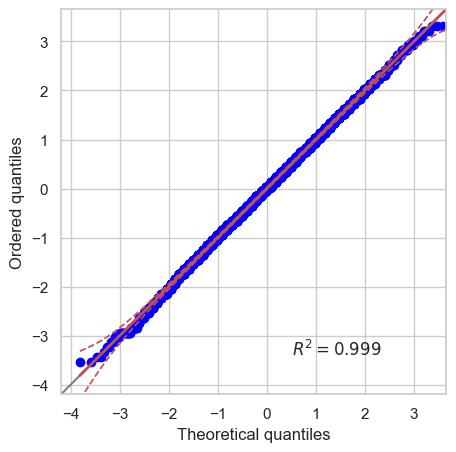

In [24]:
pg.qqplot(exp1.query('group == "A"')['events'])# можно так и другие группы просмотреть-нормально распределено

### 4

Самое время провести множественное сравнение средних! 
Передадим функции **ANOVA из пакета Pingouin** группы заказов А, B, C.
Значение статистики равно (окр. до целого) __2886__,
р-уровень значимости составил __0__. Значит группы различаются.

In [25]:
pg.anova(data=exp1,dv="events",between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


### 5

Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

__· B и C__  
__· A и C__  
· Нет значимых  
__· A и B__

In [33]:
pg.pairwise_tukey(data=exp1,dv='events', between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


In [29]:
pg.pairwise_gameshowell(data=exp1, dv="events", between="group")# Для волнующихся о неравенстве дисперсий

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


Text(0, 0.5, 'Число покупок')

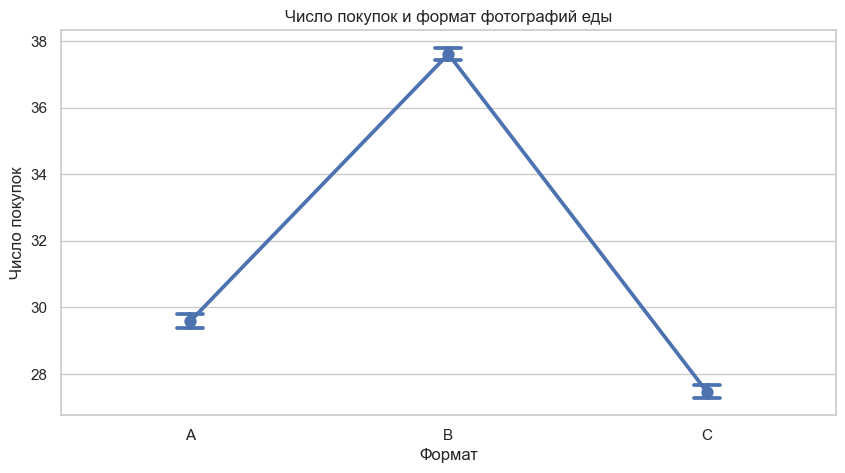

In [28]:
sns.pointplot(x='group', y='events', data=df1, capsize=.1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

### 6

Так какие картинки в итоге будем использовать?

· A – Прямоугольные, 16:9  
__· B – Квадратные (потому что среднее наибольшее и статистически значимо отличается от А & С)__  
· C – Прямоугольные, 12:4

### 7

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?

· t-test  
· хи-квадрат  
· однофакторный дисперсионный анализ  
__· многофакторный дисперсионный анализ (смотрим зависимость от 2 факторов-сегмент и версия кнопкию)__

In [5]:
exp2 = pd.read_csv('5_task_2.csv')

In [31]:
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


### 8

Посмотрим на данные. Визуализируйте распределение events для контрольной и тестовой групп.

C:\Users\konst\AppData\Local\Temp\ipykernel_7764\929986381.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query('group=="control"')['events'], kde=False, label="control")
C:\Users\konst\AppData\Local\Temp\ipykernel_7764\929986381.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2

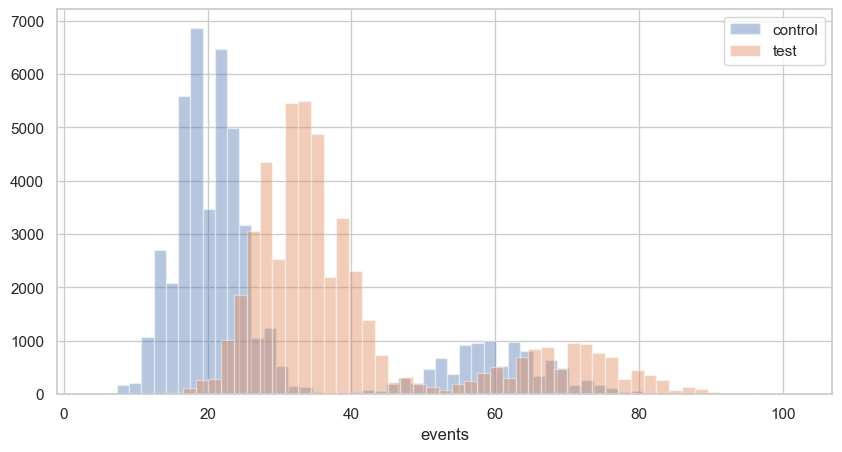

In [48]:
sns.distplot(exp2.query('group=="control"')['events'], kde=False, label="control")
sns.distplot(exp2.query('group=="test"')['events'], kde=False, label="test")
plt.legend()

C:\Users\konst\AppData\Local\Temp\ipykernel_7764\4084144660.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query('group=="control" & segment=="low"')['events'], kde=False, label="control")
C:\Users\konst\AppData\Local\Temp\ipykernel_7764\4084144660.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



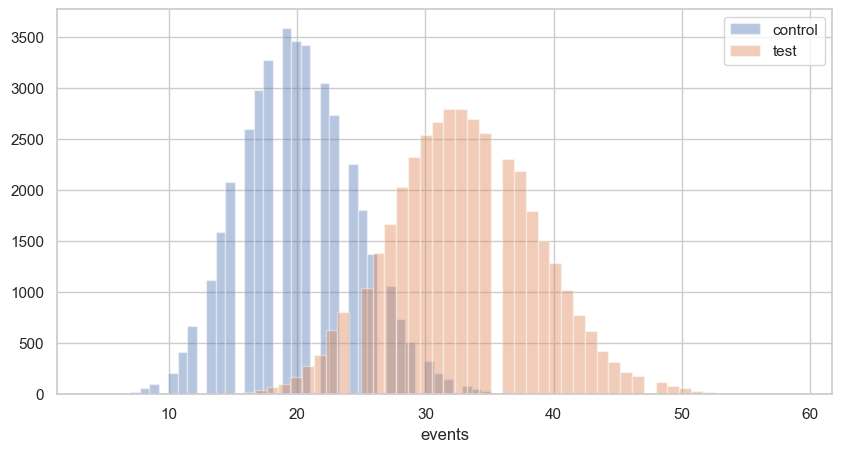

In [50]:
sns.distplot(exp2.query('group=="control" & segment=="low"')['events'], kde=False, label="control")
sns.distplot(exp2.query('group=="test" & segment=="low"')['events'], kde=False, label="test")
plt.legend()

C:\Users\konst\AppData\Local\Temp\ipykernel_7764\3037549525.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query('group=="control" & segment=="high"')['events'], kde=False, label="control")
C:\Users\konst\AppData\Local\Temp\ipykernel_7764\3037549525.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


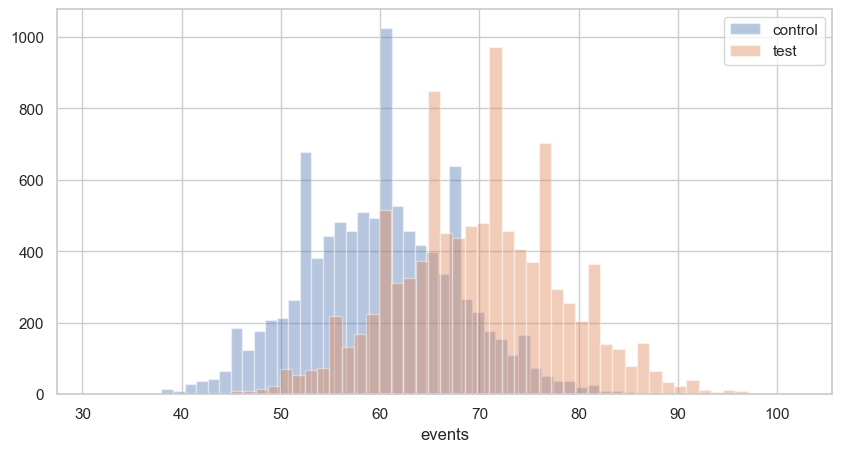

In [51]:
sns.distplot(exp2.query('group=="control" & segment=="high"')['events'], kde=False, label="control")
sns.distplot(exp2.query('group=="test" & segment=="high"')['events'], kde=False, label="test")
plt.legend()

### 9

Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

In [40]:
exp2.groupby(['group', 'segment'])['events'].describe().T.round(2)

group     control                test          
segment      high       low      high       low
count    10000.00  40000.00  10000.00  40000.00
mean        59.97     20.03     69.94     33.03
std          7.81      4.47      8.40      5.72
min         31.00      4.00     40.00     13.00
25%         55.00     17.00     64.00     29.00
50%         60.00     20.00     70.00     33.00
75%         65.00     23.00     76.00     37.00
max         89.00     41.00    102.00     59.00

### 10

Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

Если вы прибегнете к statsmodels, то какую формулу используете?

· events = segment + group  
· events = segment + group + segment:group  
__· events ~ segment + group + segment:group__  
· events ~ segment + group  
· events ~ segment, group

Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey:

In [ ]:
+-------+---------+-------------+  
| group | segment | combination |  
+-------+---------+-------------+  
| test  | high    | test / high |  
| test  | high    | test / high |  
+-------+---------+-------------+  

In [52]:
model = smf.ols(formula='events ~ segment + group + segment:group', data=exp2).fit()
aov_table = anova_lm(model, typ=2)

In [53]:
print(round(aov_table, 2))

                    sum_sq       df          F  PR(>F)
segment        23624796.65      1.0  689756.38     0.0
group           3837195.41      1.0  112031.86     0.0
segment:group     36642.44      1.0    1069.82     0.0
Residual        3424955.89  99996.0        NaN     NaN


In [57]:
print(round(pg.anova(data=exp2, dv="events", between=["group",'segment']), 2))

            Source           SS       DF           MS          F  p-unc   np2
0            group   3837195.41      1.0   3837195.41  112031.86    0.0  0.53
1          segment  23624796.65      1.0  23624796.65  689756.38    0.0  0.87
2  group * segment     36642.44      1.0     36642.44    1069.82    0.0  0.01
3         Residual   3424955.89  99996.0        34.25        NaN    NaN   NaN


**np2 gпоказывает большее влияние сегмента на клики**

In [6]:
exp2['combination'] = exp2['group'] + ' \\ ' + exp2['segment']
pg.pairwise_tukey(data=exp2, dv='events', between="combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


Между какими группами были обнаружены статистически значимые различия? Выберите верные утверждения:

· Для обоих сегментов показатели статистически значимо _уменьшились_ по сравнению с контрольной группой  
__· Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой__  
· Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 36  
__· Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13__    
__· Разница между control/high и test/high составила около 10__  
· Различий совсем не оказалось :(

### 11

Визуализируйте результаты теста и заполните пропуски:
    
Фактор group оказался __ЗНАЧИМЫМ__, фактор segment – __ЗНАЧИМЫМ__, их взаимодействие – __ЗНАЧИМО__. Судя по графику, для всех групп среднее значение events __УВЕЛИЧИЛОСЬ__, поэтому решение: __ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ__.

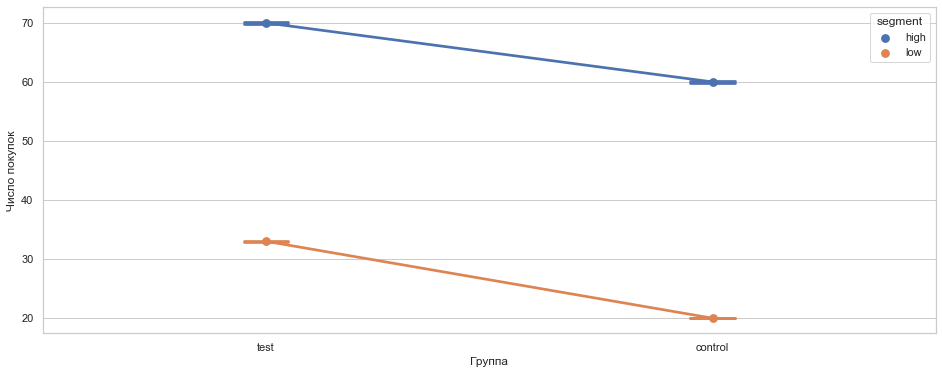

In [50]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = df2, capsize = .1)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

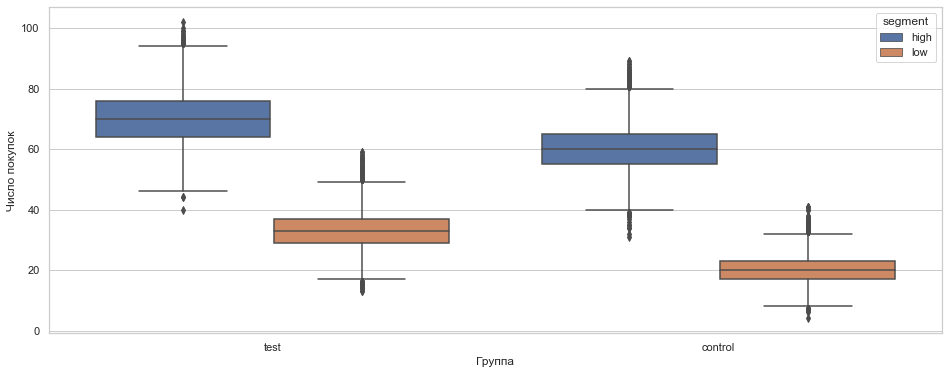

In [52]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = df2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()